In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import time
t1 = time.clock()

In [5]:
import group_data as gd
import flylib

In [6]:
def get_signal_mtrxs(swarm):
    """construct evenly sampled data matrix from a set of trials"""
    from scipy.interpolate import griddata
    signal_mtrxs = {'fly_num':[],
                    'trial_cond':[],
                    'wb_period':[],
                    'wb_frequency':[],
                    'strobe_time':[],
                    'Ph0':[],'Ph1':[],'Ph2':[],'Ph3':[],
                    'StimCond':[]}
    for fly in swarm.flies:
        #print fly.fly_num
        expmnt = fly.experiments.values()[0]
        sigs = expmnt.exp_record['tiff_data']['axon_framebase']
        trials = flylib.idx_by_thresh(np.array(sigs['StimCond']),-0.0)
        for trial in trials:
            try:
                cond = gd.get_cond(fly,trial)
                times = np.array(sigs['times'])[trial] - sigs['times'][trial[0]]
                xi = np.linspace(0,23,1150)
                signal_mtrxs['fly_num'].append(fly.fly_num)
                signal_mtrxs['trial_cond'].append(cond)
                for skey in ['wb_period','wb_frequency','strobe_time','Ph0','Ph1','Ph2','Ph3','StimCond']:
                    resamp = griddata(times,np.array(sigs[skey])[trial],xi,method = 'linear')
                    signal_mtrxs[skey].append(resamp)
            except ValueError:
                print 'ValueError'
    for skey in signal_mtrxs.keys():
        signal_mtrxs[skey] = np.array(signal_mtrxs[skey])
    signal_mtrxs['LmR'] = signal_mtrxs['Ph0'] - signal_mtrxs['Ph1']
    signal_mtrxs['LpR'] = signal_mtrxs['Ph0'] + signal_mtrxs['Ph1']
    d_matrix = array([signal_mtrxs['fly_num'] == fly.fly_num for fly in swarm.flies])
    return signal_mtrxs,d_matrix,xi
def get_inclusion(signal_mtrxs,
                  condition,
                  min_wbfreq = 180,
                  trial_prop = 0.9):
    """ get the trial inclusion vector for a given condition"""
    trial_len = shape(signal_mtrxs['wb_frequency'])[1]
    #wbfreq was greater than min_wbfreq for > trial_prop of the trial
    criterion = sum(signal_mtrxs['wb_frequency']>min_wbfreq,axis = 1)>(trial_len*trial_prop)
    criterion *= sum(~isfinite(signal_mtrxs['wb_frequency']),axis = 1) == 0
    #criterion *= ~(sum(signal_mtrxs['wb_frequency']>250,axis = 1) > 0)
    #print ~(sum(signal_mtrxs['wb_frequency']>250,axis = 1) > 0)
    #encode = {'regressive':1,'descending':2,'progressive':3,'ascending':4,'flow_right':5,'flow_left':6}
    include = signal_mtrxs['trial_cond'] == gd.encode[condition]
    include *= criterion
    return include

def calc_summary_stats(signal_mtrxs,
                       design_mtrx,
                       signal,
                       include,
                       decode = None,
                       min_num_trials = 5):
    """ return the summary stats - within cell --fly-- means, as well as grand mean 
    and std. Pass a dictionary of signal matrixs 'signal_mtrxs', the experimental
    design matrx 'design_mtrx', the signal of interest, and a 
    binary vector indicating the included trials. Note that the independent 'cells' are
    specified by the design matrix and does not necessarily need to be single fly"""
    data = signal_mtrxs[signal]*include.T[:,np.newaxis]
    trials_in_flies = dot(design_mtrx.astype(float),include.astype(float))[:,newaxis]
    sum_flies = dot(design_mtrx,nan_to_num(data))
    include_flies = squeeze(trials_in_flies > min_num_trials)
    #individual fly means
    cell_means = sum_flies[include_flies]/trials_in_flies[include_flies]
    #mean across group
    grand_mean = mean(decode(cell_means),axis = 0)
    #std across group
    grand_std = std(decode(cell_means),axis = 0)
    return {'cell_means':cell_means,'grand_mean':grand_mean,'grand_std':grand_std}
def plot_fly_behavior(signal_mtrxs,design_mtrx,xi):
    condition_plotdata = {'flow_right':   {'column':0,'color':'r'},
                      'flow_left':  {'column':0,'color':'b'},
                      'progressive':  {'column':1,'color':'r'},
                      'regressive': {'column':1,'color':'b'},
                      'ascending':   {'column':2,'color':'r'},
                      'descending': {'column':2,'color':'b'}}

    signal_plotdata = {'Ph0':          {'row':0,'decode': lambda x: rad2deg(x/5), 'ybound':(0,90),    'label':'Lwing'},
                       'Ph1':          {'row':1,'decode': lambda x: rad2deg(x/5), 'ybound':(0,90),    'label':'Rwing'},
                       'LmR':          {'row':2,'decode': lambda x: rad2deg(x/5), 'ybound':(-60,60),  'label':'L-R'  },
                       'LpR':          {'row':3,'decode': lambda x: rad2deg(x/5), 'ybound':(40,140),  'label':'L+R'  },
                       'wb_frequency': {'row':4,'decode': lambda x: x,            'ybound':(180,240), 'label':'freq' }}

    condition_list = ['flow_right','flow_left','progressive','regressive','ascending','descending']
    import matplotlib.gridspec as gridspec
    gs = gridspec.GridSpec(5, 3)

    for skey in signal_plotdata.keys():
        for condition in condition_plotdata.keys():
            ax = plt.subplot(gs[signal_plotdata[skey]['row'], 
                                condition_plotdata[condition]['column']])
            axvspan(10, 13, ymin=0, ymax=1, alpha = 0.1,facecolor = 'k',edgecolor = (0,0,0,0))
            include = get_inclusion(signal_mtrxs,condition)
            summary_data = calc_summary_stats(signal_mtrxs,
                                              design_mtrx,
                                              skey,
                                              include,
                                              decode = signal_plotdata[skey]['decode'])
            grand_mean = summary_data['grand_mean']
            grand_std = summary_data['grand_std']
            lns = plot(xi,grand_mean,alpha = 1.0,color = condition_plotdata[condition]['color'])
            lns = fill_between(xi,
                               grand_mean+grand_std,
                               grand_mean-grand_std,
                               alpha = 0.3,color = condition_plotdata[condition]['color'],lw = 0.1)
            n = shape(summary_data['cell_means'])[0]
            ax.set_ybound(signal_plotdata[skey]['ybound'])
            
            if condition_plotdata[condition]['column'] >0:
                ax.set_yticklabels([])
            else:
                ax.set_ylabel(signal_plotdata[skey]['label'])
            if signal_plotdata[skey]['row'] < 4:
                ax.set_xticklabels([])
            if signal_plotdata[skey]['row'] == 0:
                if condition_plotdata[condition]['color'] == 'r':
                    ax.annotate('%s n=%s'%(condition,n),xy = (0.10,0.8),xycoords='axes fraction',color = 'r')
                else:
                    ax.annotate('%s n=%s'%(condition,n),xy = (0.10,0.65),xycoords='axes fraction',color = 'b')
            
            ax.set_xbound(0,23)

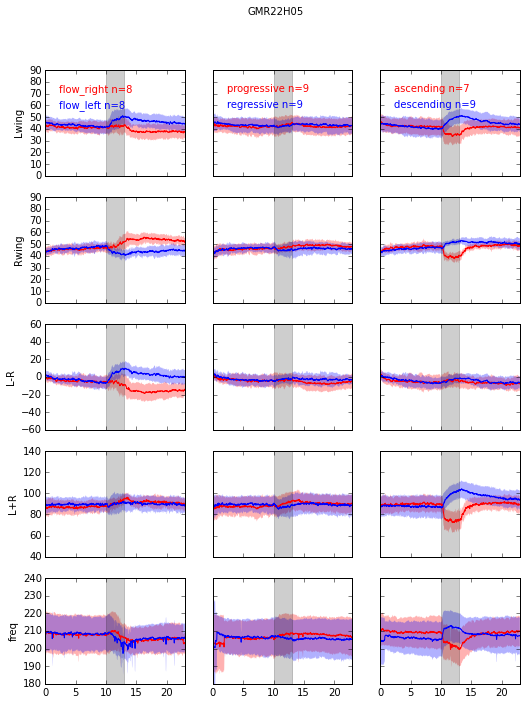

In [7]:
figure(figsize = (8.5,11))
plot_fly_behavior(*get_signal_mtrxs(gd.GMR22H05_swarm))
gcf().suptitle('GMR22H05')
savefig('./behavioral_summaries/GMR22H05_behavior.pdf')
display(gcf());close()

/home/psilentp/anaconda/lib/python2.7/site-packages/scipy/interpolate/interpolate.py:445: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/psilentp/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/psilentp/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:71: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/psilentp/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:41: RuntimeWarning: invalid value encountered in greater


ValueError


/home/psilentp/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply


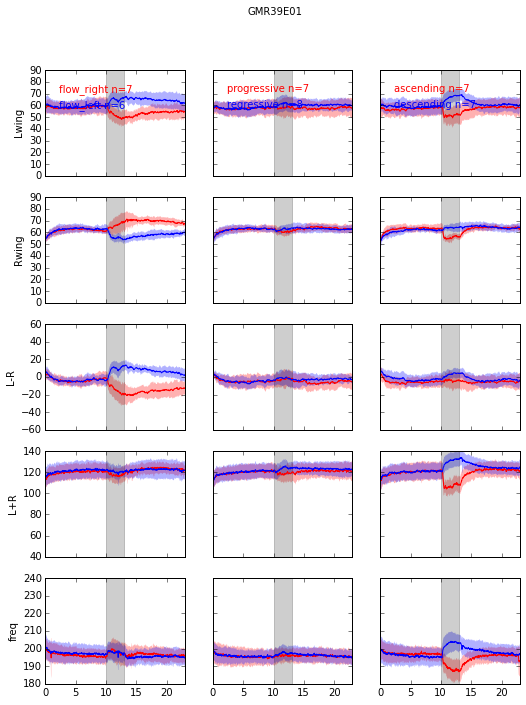

In [8]:
figure(figsize = (8.5,11))
plot_fly_behavior(*get_signal_mtrxs(gd.GMR39E01_swarm))
gcf().suptitle('GMR39E01')
savefig('./behavioral_summaries/GMR39E01_behavior.pdf')
display(gcf());close()

ValueError


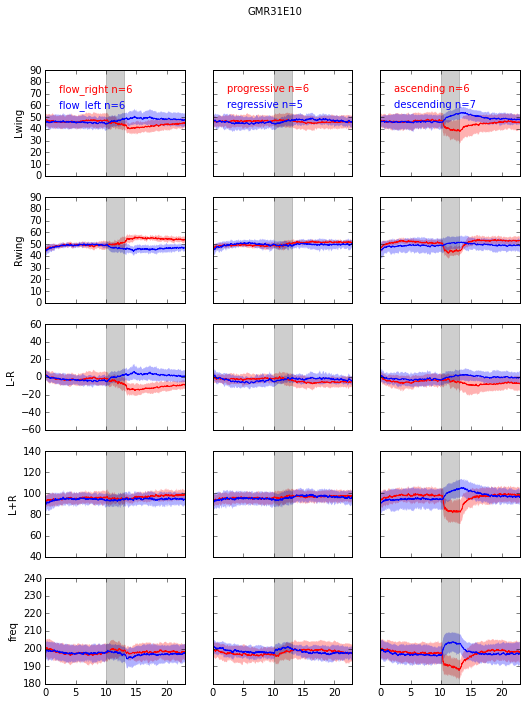

In [9]:
figure(figsize = (8.5,11))
plot_fly_behavior(*get_signal_mtrxs(gd.GMR31E10_swarm))
gcf().suptitle('GMR31E10')
savefig('./behavioral_summaries/GMR31E10_behavior.pdf')
display(gcf());close()

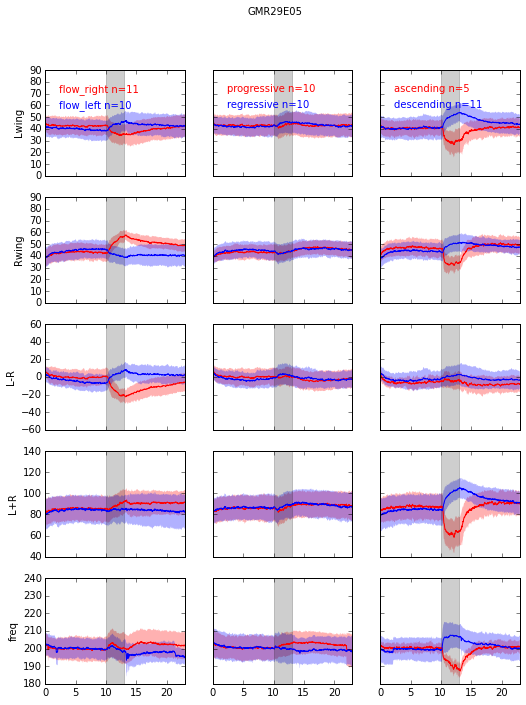

In [10]:
figure(figsize = (8.5,11))
plot_fly_behavior(*get_signal_mtrxs(gd.GMR29E05_swarm))
gcf().suptitle('GMR29E05')
savefig('./behavioral_summaries/GMR29E05_behavior.pdf')
display(gcf());close()

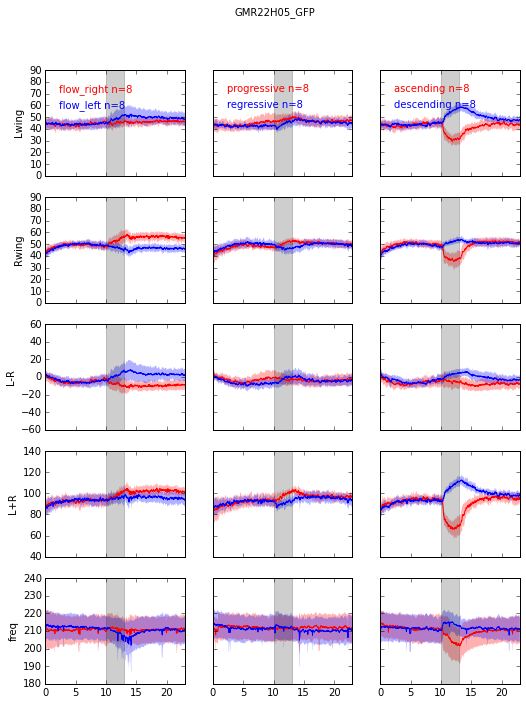

In [11]:
figure(figsize = (8.5,11))
plot_fly_behavior(*get_signal_mtrxs(gd.GMR22H05_GFP_swarm))
gcf().suptitle('GMR22H05_GFP')
savefig('./behavioral_summaries/GMR22H05_GFP_behavior.pdf')
display(gcf());close()

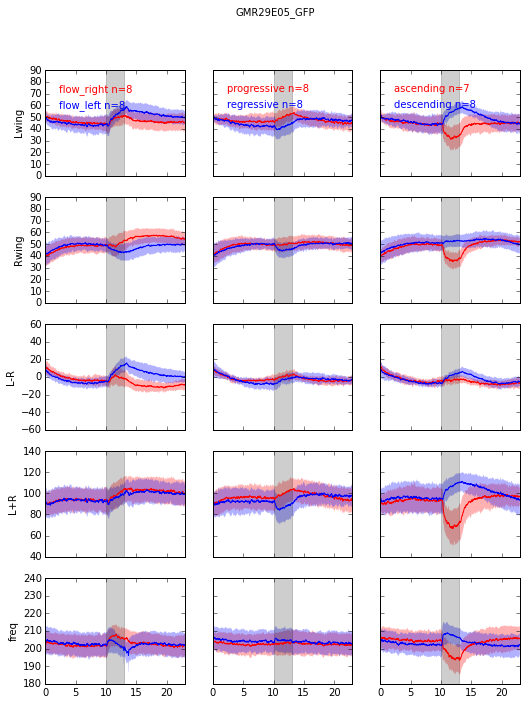

In [12]:
figure(figsize = (8.5,11))
plot_fly_behavior(*get_signal_mtrxs(gd.GMR29E05_GFP_swarm))
gcf().suptitle('GMR29E05_GFP')
savefig('./behavioral_summaries/GMR29E05_GFP_behavior.pdf')
display(gcf());close()

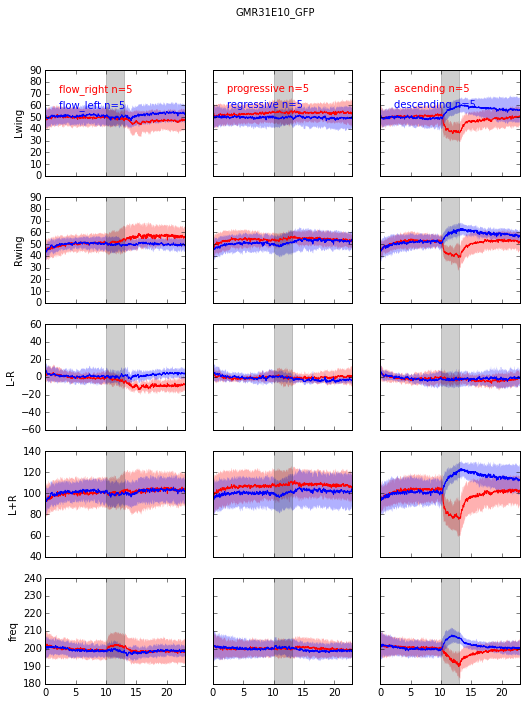

In [13]:
figure(figsize = (8.5,11))
plot_fly_behavior(*get_signal_mtrxs(gd.GMR31E10_GFP_swarm))
gcf().suptitle('GMR31E10_GFP')
savefig('./behavioral_summaries/GMR31E10_GFP_behavior.pdf')
display(gcf());close()

ValueError


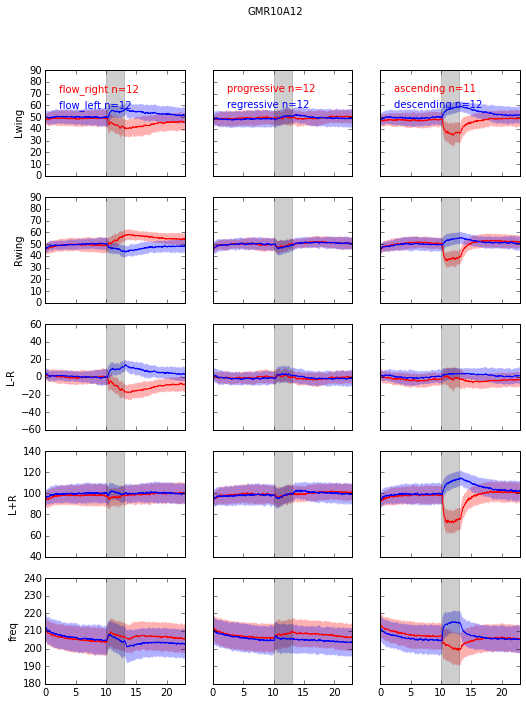

In [14]:
figure(figsize = (8.5,11))
plot_fly_behavior(*get_signal_mtrxs(gd.GMR10A12_swarm))
gcf().suptitle('GMR10A12')
savefig('./behavioral_summaries/GMR10A12_behavior.pdf')
display(gcf());close()

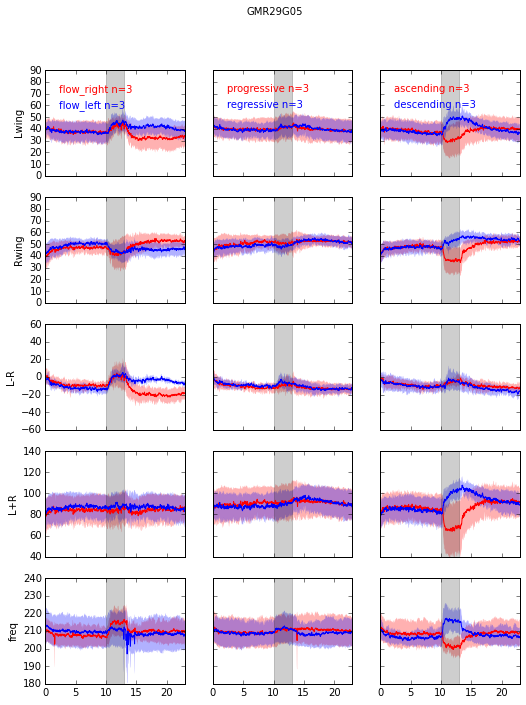

In [15]:
figure(figsize = (8.5,11))
plot_fly_behavior(*get_signal_mtrxs(gd.GMR29G05_swarm))
gcf().suptitle('GMR29G05')
savefig('./behavioral_summaries/GMR29G05_behavior.pdf')
display(gcf());close()

ValueError


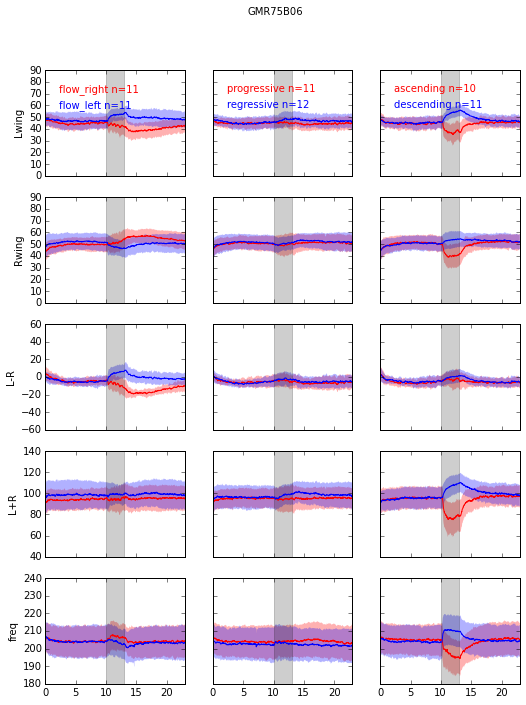

In [16]:
figure(figsize = (8.5,11))
plot_fly_behavior(*get_signal_mtrxs(gd.GMR75B06_swarm))
gcf().suptitle('GMR75B06')
savefig('./behavioral_summaries/GMR75B06_behavior.pdf')
display(gcf());close()

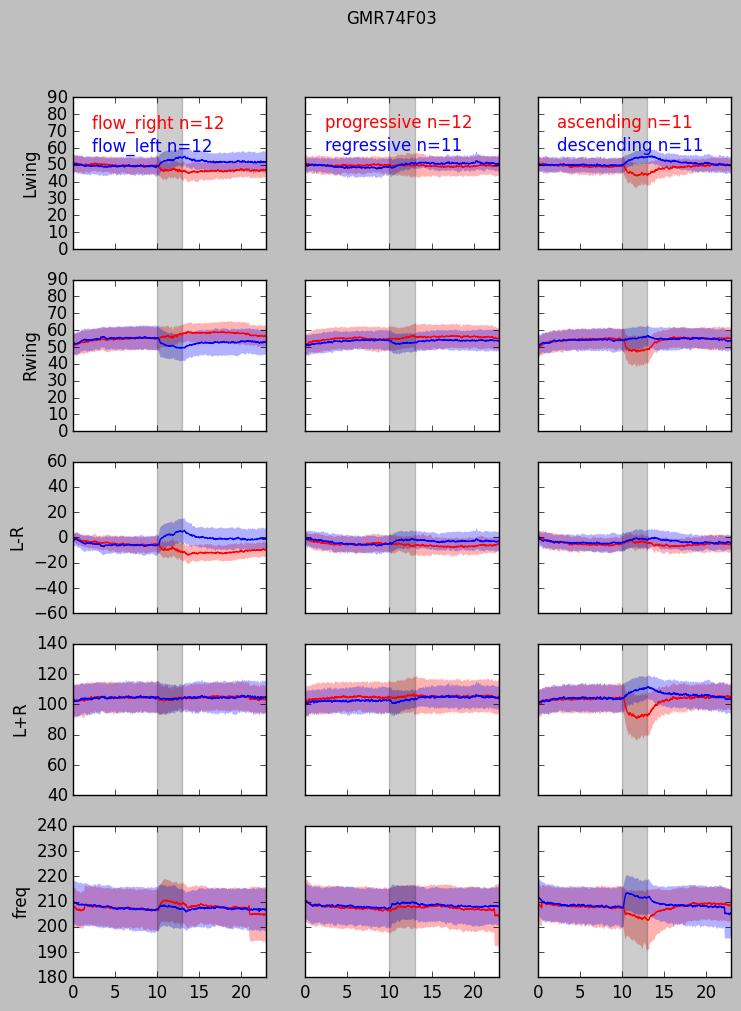

In [17]:
figure(figsize = (8.5,11))
plot_fly_behavior(*get_signal_mtrxs(gd.GMR74F03_swarm))
gcf().suptitle('GMR74F03')
savefig('./behavioral_summaries/GMR74F03_behavior.pdf')
display(gcf());close()

In [18]:
t2 = time.clock()
print t1-t2

-263.351472


In [ ]:
240